# Preliminary Data Analysis

In [78]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import dowhy

## Players preprocess

In [79]:
players_df = pd.read_csv(r'data\players.csv')
for col in players_df.columns:
    if 'career' in col:
        players_df.drop(col, axis=1, inplace=True)
players_df = players_df[players_df['draft_pick'].notna()] # remove players with no draft pick
players_df = players_df[players_df["draft_pick"].str.contains('overall')] # remove players with no valid draft pick
# drop the 'height' column
players_df = players_df.drop(columns=['height'])
# remove all players 
players_df = players_df[players_df['draft_round'].notna()] # remove players with no draft pick
players_df = players_df[players_df["draft_round"].str.contains('1') | players_df["draft_round"].str.contains('2')] # remove players with no valid draft pick

# Remove all non-numeric digits frpm the draft pick column and convert to int
players_df['draft_pick'] = players_df['draft_pick'].str.replace(r'\D', '',  regex=True).astype(int) # remove all non-numeric digits from the draft pick column and convert to int
players_df['draft_round'] = players_df['draft_round'].str.replace(r'\D', '', regex=True).astype(int) # remove all non-numeric digits from the draft round column and convert to int
players_df['weight'] = players_df['weight'].str.replace(r'\D', '', regex=True).astype(int) # remove all non-numeric digits from the weight column and convert to int
players_df['position'] = players_df['position'].apply(lambda x: tuple(re.split(' and |, |/',x))[0]) # remove all positions after the first

players_df['birthDate'] = pd.to_datetime(players_df['birthDate']) # convert birthDate to datetime
players_df['birthYear'] = players_df["birthDate"].dt.year.notnull().astype(int) # create birthYear column
players_df.drop(['birthDate'], axis = 1, inplace = True) 

players_df['draft_year'] = players_df['draft_year'].astype(int) # convert draft_year to int
players_df = players_df.drop(players_df[players_df['draft_pick'] > 60].index) # remove players with draft pick > 60


In [80]:
# add height from the Players_height.csv file based on the player's name
players_height_df = pd.read_csv(r'data\Players_height.csv') 
players_height_df = players_height_df[['Player', 'height']]
players_height_df = players_height_df.rename(columns={'Player': 'name'})
players_df = pd.merge(players_df, players_height_df, on='name', how='left')


In [81]:
percent_missing = players_df.isnull().sum() * 100 / len(players_df)
missing_value_players_df = pd.DataFrame({'column_name': players_df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_players_df

,column_name,percent_missing
0,_id,0.000000
1,birthPlace,2.796919
2,college,8.877179
3,draft_pick,0.000000
4,draft_round,0.000000
5,draft_team,0.000000
6,draft_year,0.000000
7,highSchool,8.350223
8,name,0.000000
9,position,0.000000


In [82]:
players_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,shoots,weight,birthYear,height
0,smartke01,"Baton Rouge, Louisiana",Indiana University,41,2,Golden State Warriors,1988,"McKinley in Baton Rouge, Louisiana",Keith Smart,Point Guard,Right,175,1,185.0
1,belltr01,"Minneapolis, Minnesota",Boston College,16,1,Boston Celtics,2003,"Academy of Holy Angels in Richfield, Minnesota",Troy Bell,Point Guard,Right,180,1,185.0
2,kileyja01,NaN,Syracuse University,13,2,Fort Wayne Pistons,1951,NaN,Jack Kiley,Shooting Guard,Right,170,1,185.0
3,tonkoan01,"Barrackville, West Virginia",Marshall University,1,1,Providence Steamrollers,1948,"Union in Benwood, West Virginia",Andy Tonkovich,Guard,Right,185,1,NaN
4,paigema01,"Cedar Rapids, Iowa",University of North Carolina,55,2,Brooklyn Nets,2016,"Linn-Marr in Marion, Iowa",Marcus Paige,Point Guard,Left,175,1,NaN


## Salaries preprocess

In [83]:
salary_df = pd.read_csv(r'data\salaries_1985to2018.csv')

# drop the 'season_start', 'team' and 'season' columns
salary_df = salary_df.drop(columns=['season_start', 'team', 'season', 'league'])
salary_df = salary_df.rename(columns={'season_end': 'Year', 'player_id': '_id'})
print(salary_df.dtypes)

_id       object
salary     int64
Year       int64
dtype: object


In [84]:
percent_missing = salary_df.isnull().sum() * 100 / len(salary_df)
missing_value_salary_df = pd.DataFrame({'column_name': salary_df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)
missing_value_salary_df

,column_name,percent_missing
0,_id,0.0
1,salary,0.0
2,Year,0.0


In [85]:
salary_df.head(5)

,_id,salary,Year
0,abdelal01,395000,1991
1,abdelal01,494000,1992
2,abdelal01,500000,1993
3,abdelal01,805000,1994
4,abdelal01,650000,1995


## Merge the 2 datasets and add 'season stats' dataset

The 'season stats' dataset contains data about the players' performance in each season throughout multiple seasons.

In [86]:
ps_df = pd.merge(players_df, salary_df, on='_id', how='right')
ps_df['draft_pick'] = ps_df['draft_pick'].astype('Int64')
ps_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,shoots,weight,birthYear,height,salary,Year
0,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,395000,1991
1,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,494000,1992
2,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,500000,1993
3,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,805000,1994
4,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,Right,240.0,1.0,208.0,650000,1995


In [87]:
p_stats_df = pd.read_csv(r'data\Seasons_Stats.csv')
p_stats_df = p_stats_df.rename(columns={'Player': 'name'})
p_stats_df = p_stats_df[['name', 'Year', 'Tm', 'PER', 'PTS', 'TS%', 'MP', 'OWS', 'DWS', 'WS/48', 'FG%', 'AST']]
ps_df = pd.merge(ps_df, p_stats_df, on=['name', 'Year'], how='left')

In [88]:
ps_df = ps_df[ps_df['salary'].notna()]
ps_df = ps_df[ps_df['draft_pick'].notna()]
ps_df = ps_df[ps_df['PER'].notna()]
ps_df = ps_df.drop(ps_df[ps_df['Year'] - ps_df['draft_year'] > 5].index) # Keep only first 5 seasons after draft for each player
ps_df.head(5)

,_id,birthPlace,college,draft_pick,draft_round,draft_team,draft_year,highSchool,name,position,...,Tm,PER,PTS,TS%,MP,OWS,DWS,WS/48,FG%,AST
0,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,POR,13.1,135.0,0.499,290.0,0.0,0.5,0.079,0.474,12.0
1,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,POR,13.5,432.0,0.533,934.0,0.6,1.5,0.110,0.493,30.0
2,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,TOT,13.2,578.0,0.551,1311.0,0.7,1.3,0.074,0.518,27.0
3,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,MIL,11.9,64.0,0.508,159.0,0.0,0.2,0.035,0.464,10.0
4,abdelal01,"Cairo, Egypt",Duke University,25,1.0,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Alaa Abdelnaby,Power Forward,...,BOS,13.4,514.0,0.557,1152.0,0.7,1.2,0.079,0.525,17.0


# Analysis of average salary over first 5 years of the career

In [89]:
# devide the salaries by the mean salary of each year
mean_salary_df = ps_df[['Year', 'salary']].groupby(['Year']).median().reset_index()
mean_salary_df = mean_salary_df.rename(columns={'salary': 'mean_salary'})
ps_df_year_norm = pd.merge(ps_df, mean_salary_df, on='Year', how='left')
ps_df_year_norm['salary'] = ps_df_year_norm['salary'] / ps_df_year_norm['mean_salary']
ps_df_year_norm = ps_df_year_norm.drop(columns=['mean_salary'])


teams_df = ps_df[['Tm', '_id']].groupby('_id').first().reset_index()
avg_salary = ps_df[['PER', '_id', 'salary', 'draft_pick', 'draft_year']].groupby(['_id']).mean().reset_index()
avg_salary = pd.merge(avg_salary, teams_df, on='_id', how='left')
avg_salary['draft_pick'] = avg_salary['draft_pick'].astype('Int64')
avg_salary['draft_year'] = avg_salary['draft_year'].astype('Int64')

avg_salary_year_norm = ps_df_year_norm[['PER', '_id', 'salary', 'draft_pick', 'draft_year']].groupby(['_id']).mean().reset_index()
avg_salary_year_norm = pd.merge(avg_salary_year_norm, teams_df, on='_id', how='left')
avg_salary_year_norm['draft_pick'] = avg_salary_year_norm['draft_pick'].astype('Int64')
avg_salary_year_norm['draft_year'] = avg_salary_year_norm['draft_year'].astype('Int64')
avg_salary_year_norm

,_id,PER,salary,draft_pick,draft_year,Tm
0,abdelal01,9.833333,0.745210,25,1990,POR
1,abdulma02,14.980000,2.823922,3,1990,DEN
2,abdulta01,9.655556,2.390801,11,1997,SAC
3,abdursh01,18.900000,5.835999,3,1996,VAN
4,abrinal01,10.100000,3.120128,32,2013,OKC
...,...,...,...,...,...,...
1538,zhizhwa01,16.037500,1.007511,36,1999,DAL
1539,zidekge01,9.971429,0.633519,22,1995,CHH
1540,zimmest01,7.300000,0.494452,41,2016,ORL
1541,zipsepa01,6.900000,0.390357,48,2016,CHI


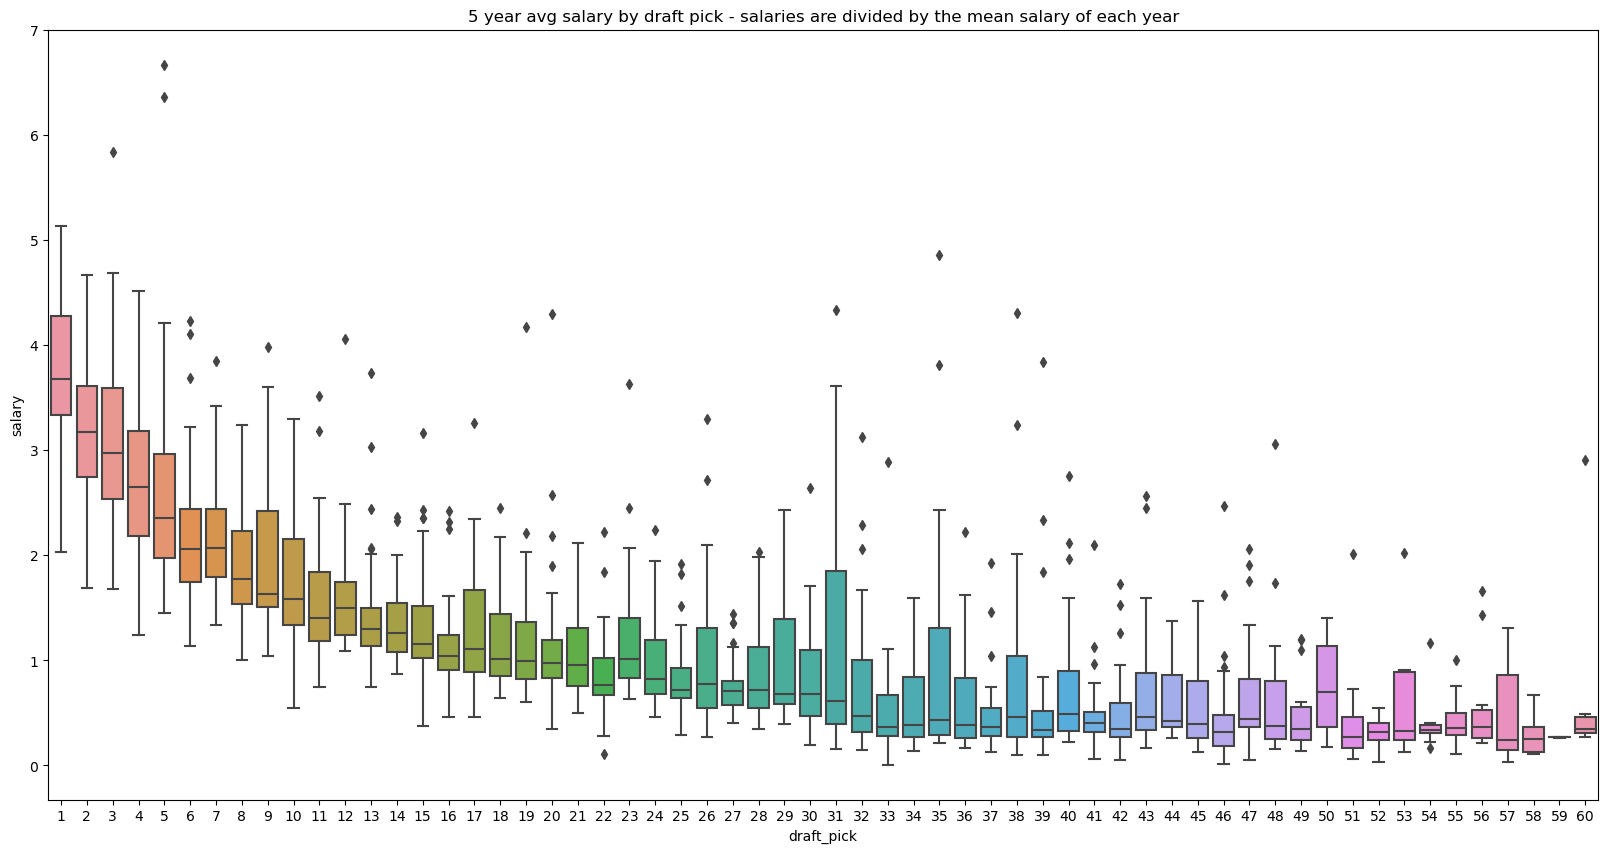

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=avg_salary_year_norm, x='draft_pick', y='salary')
plt.title('5 year avg salary by draft pick - salaries are divided by the mean salary of each year')
plt.show()

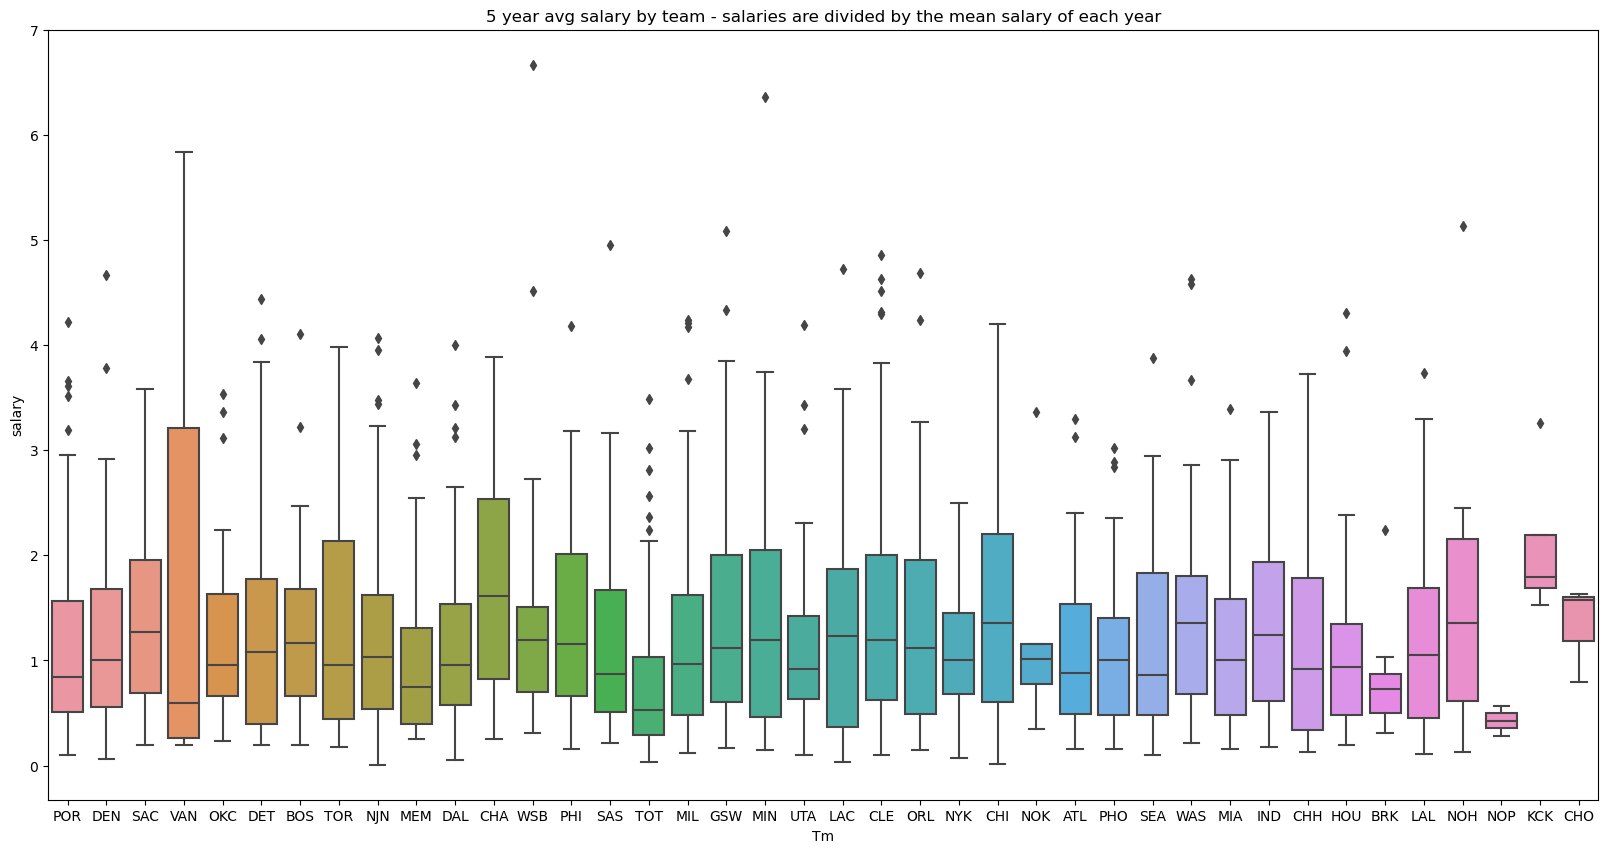

In [91]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=avg_salary_year_norm, x='Tm', y='salary')
plt.title('5 year avg salary by team - salaries are divided by the mean salary of each year')
plt.show()

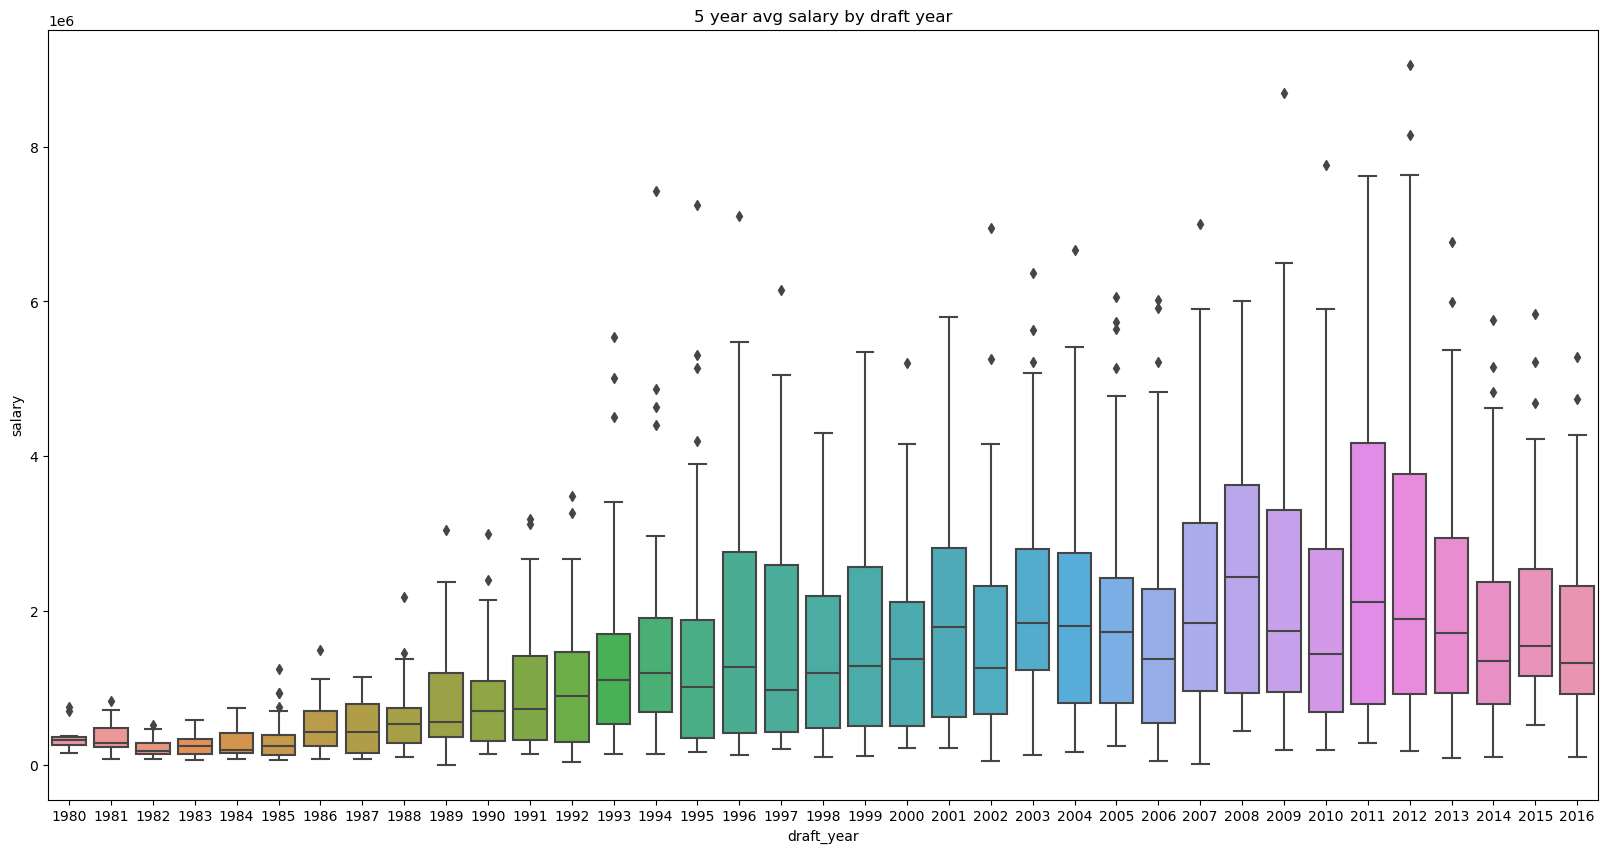

In [92]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=avg_salary, x='draft_year', y='salary')
plt.title('5 year avg salary by draft year')
plt.show()

# Create causal model

## Add treatment variable and filter the dataset accordingly

### Not normalized by year mean salary

In [227]:
upper_bound = 1
lower_bound = 60 # This is lower because it refers to decreasing placement
ps_treat_df = ps_df[(ps_df['draft_pick'] <= lower_bound) & (ps_df['draft_pick'] >= upper_bound)] # Keep only relevant players who were selected between places 28-33

# 1- better placement, 0- worse placement
ps_treat_df['T'] = ps_treat_df['draft_pick'].apply(lambda x: 1 if x <= upper_bound + (lower_bound - upper_bound)/2 else 0).to_numpy()

avg_treat_salary = ps_treat_df[['PER', '_id', 'salary', 'draft_pick', 'draft_year', 'T']].groupby(['_id']).mean().reset_index()

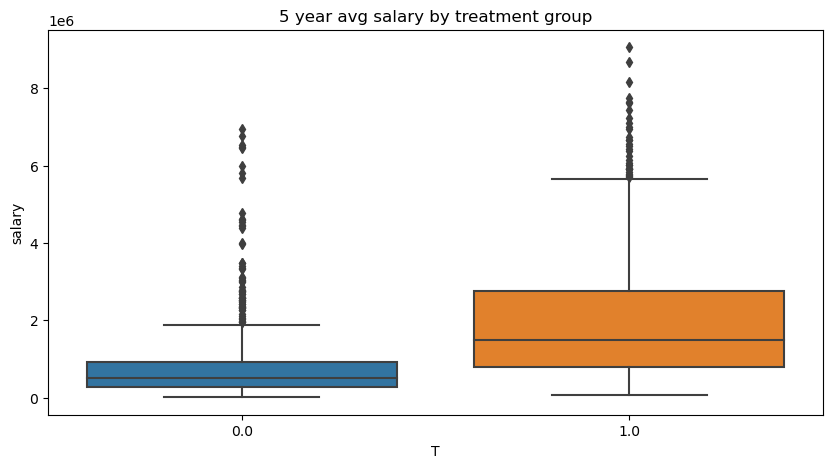

In [228]:
# Not normalized by year mean salary
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=avg_treat_salary, x='T', y='salary')
plt.title('5 year avg salary by treatment group')
plt.show()

### Normalized by year mean salary

In [229]:
ps_treat_df_year_norm = ps_df_year_norm[(ps_df_year_norm['draft_pick'] <= lower_bound) & (ps_df_year_norm['draft_pick'] >= upper_bound)] # Keep only relevant players who were selected between places 28-33

# 1- better placement, 0- worse placement
ps_treat_df_year_norm['T'] = ps_treat_df_year_norm['draft_pick'].apply(lambda x: 1 if x <= upper_bound + (lower_bound - upper_bound)/2 else 0).to_numpy()

avg_treat_salary_year_norm = ps_treat_df_year_norm[['PER', '_id', 'salary', 'draft_pick', 'draft_year', 'T']].groupby(['_id']).mean().reset_index()

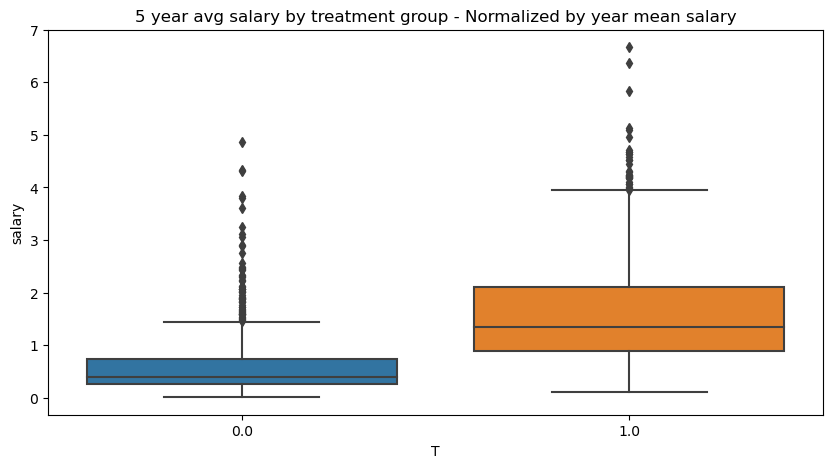

In [230]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=avg_treat_salary_year_norm, x='T', y='salary')
plt.title('5 year avg salary by treatment group - Normalized by year mean salary')
plt.show()

### Assumption: All variables that have something to do with the player's talent, even though they are messured after the draft we will treat them as if they represent the objective talent of the player that has not changed over the years.

Now we will check how plausible this assumption is. we will check how the personal performance covariates change throughout the years using the player_stats dataset.

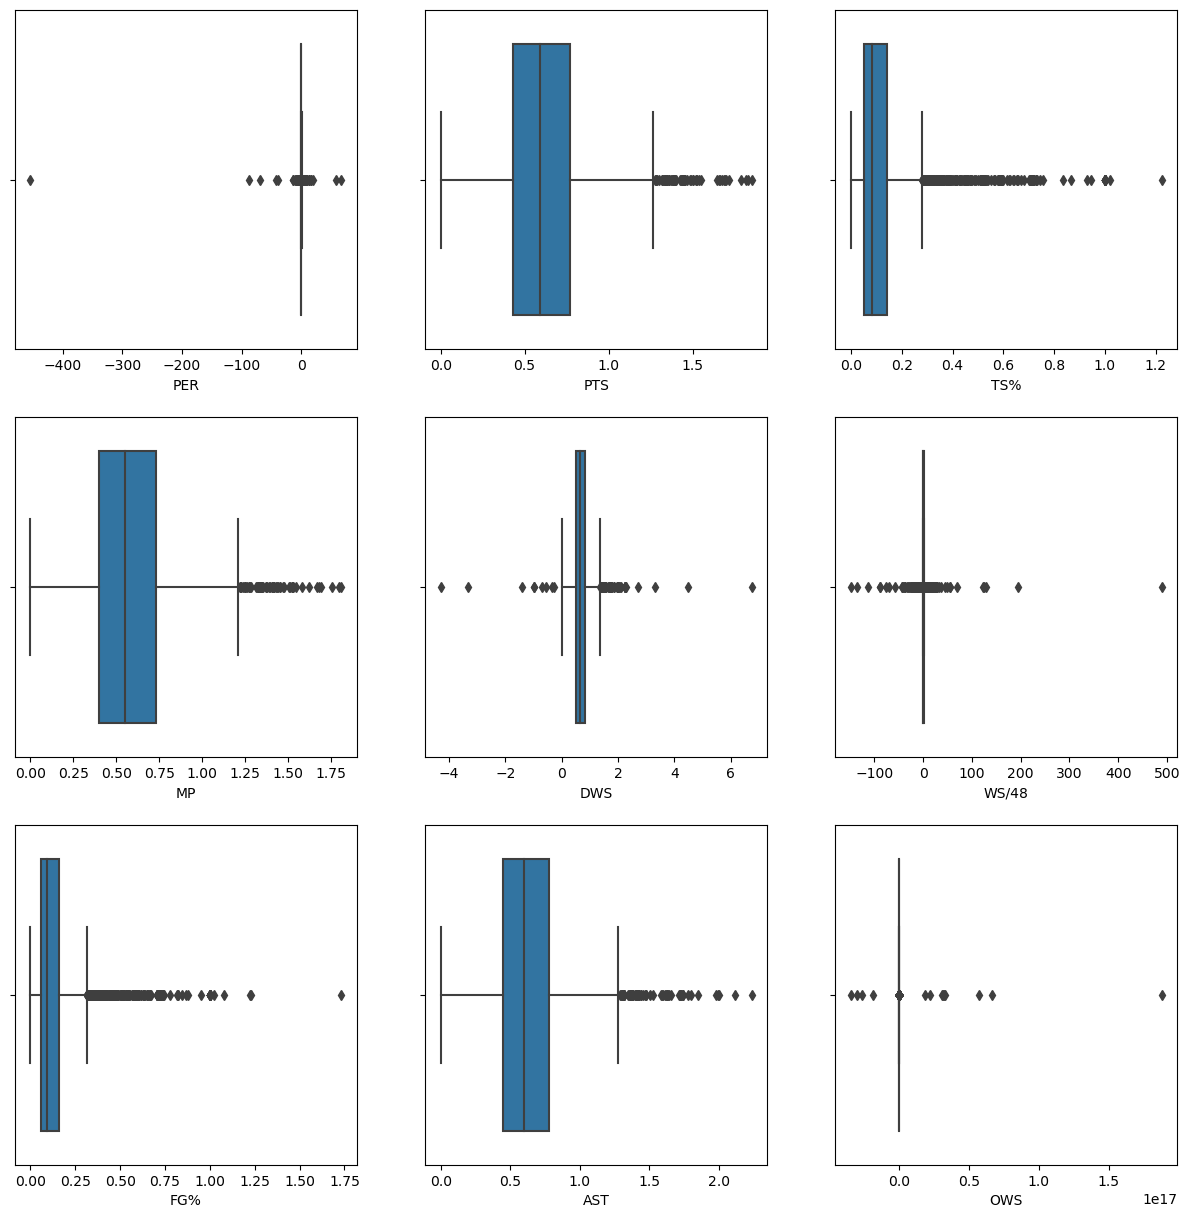

In [231]:
p_agg_stats = p_stats_df[['name', 'PER', 'PTS', 'TS%', 'MP', 'DWS', 'WS/48', 'FG%', 'AST', 'OWS']]
def compute_std_over_mean(x): # Coefficient of variation, which is a dimensionless measure of dispersion of a probability distribution around the mean
    if x.notnull().sum().sum() <= 1:
        return np.nan
    return np.std(list(x))/np.nanmean(list(x)) if np.nanmean(x.tolist()) != 0 else np.nan
    
personal_stats_df = p_agg_stats.groupby('name').agg(compute_std_over_mean)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for idx, col_name in enumerate(personal_stats_df.columns):
    ax = sns.boxplot(x=col_name, ax=axes[idx//3, idx%3], data=personal_stats_df)
plt.show()

## Create causal graph and causal model

In [232]:
from pandas.api.types import is_numeric_dtype
from scipy import stats

def mean_str(col):
    if is_numeric_dtype(col):
        return col.mean()
    else:
        return col.mode()

avg_treat_salary = ps_treat_df.copy()
avg_treat_salary.sort_values(by='Year', ascending=True, inplace=True)
avg_treat_salary = avg_treat_salary.groupby('_id').agg(mean_str)
avg_treat_salary = avg_treat_salary.drop(columns=['Year', 'name', 'draft_round', 'draft_pick', 'Tm', 'shoots', 'weight']) # Delete irrelevant columns
avg_treat_salary['college'] = avg_treat_salary['college'].apply(lambda x: None if type(x)!=str else x)
avg_treat_salary['highSchool'] = avg_treat_salary['highSchool'].apply(lambda x: None if type(x)!=str else x)
# # Remove outliers
# for col in avg_treat_salary.columns:
#     if is_numeric_dtype(avg_treat_salary[col]):
#         avg_treat_salary = avg_treat_salary[(np.abs(stats.zscore(avg_treat_salary[col])) < 8)]

In [233]:
avg_treat_salary

,birthPlace,college,draft_team,draft_year,highSchool,position,birthYear,height,salary,PER,PTS,TS%,MP,OWS,DWS,WS/48,FG%,AST,T
_id,,,,,,,,,,,,,,,,,,,
abdelal01,"Cairo, Egypt",Duke University,Portland Trail Blazers,1990.0,"Bloomfield in Bloomfield, New Jersey",Power Forward,1.0,208.0,5.715556e+05,9.833333,255.444444,0.475889,557.444444,0.111111,0.688889,-0.004000,0.449333,13.888889,1.0
abdulma02,"Gulfport, Mississippi",Louisiana State University,Denver Nuggets,1990.0,"Gulfport in Gulfport, Mississippi",Point Guard,1.0,188.0,2.010200e+06,14.980000,1186.800000,0.499200,2090.400000,2.060000,1.280000,0.063600,0.442800,273.400000,1.0
abdulta01,"Maisons Alfort, France","University of Michigan, San Jose State University",Sacramento Kings,1997.0,"Lycee Aristide Briand in Evreux, France",Shooting Guard,1.0,198.0,3.012238e+06,9.655556,289.444444,0.403444,735.777778,-0.088889,0.666667,0.005333,0.358222,40.777778,1.0
abdursh01,"Marietta, Georgia",University of California,Vancouver Grizzlies,1996.0,"Wheeler in Marietta, Georgia",Center,1.0,206.0,7.105333e+06,18.900000,1606.666667,0.538000,3088.666667,4.500000,2.233333,0.102333,0.463333,232.000000,1.0
abrinal01,"Palma de Mallorca, Spain",None,Oklahoma City Thunder,2013.0,None,Shooting Guard,1.0,198.0,5.994764e+06,10.100000,406.000000,0.560000,1055.000000,1.200000,0.900000,0.095000,0.393000,40.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhizhwa01,"Beijing, China",None,Dallas Mavericks,1999.0,None,Center,1.0,213.0,1.278585e+06,16.037500,84.750000,0.541625,183.500000,0.125000,0.125000,0.128375,0.289875,5.000000,0.0
zidekge01,"Zlin, Czech Republic","University of California, Los Angeles",Charlotte Hornets,1995.0,"Arabska Secondary in Arabska, Czech Republic",Center,1.0,213.0,7.196571e+05,9.971429,89.285714,0.461571,252.571429,0.028571,0.100000,0.014286,0.347571,6.857143,1.0
zimmest01,"Hendersonville, Tennessee","University of Nevada, Las Vegas",Orlando Magic,2016.0,"Bishop Gorman in Las Vegas, Nevada",Center,1.0,213.0,9.500000e+05,7.300000,23.000000,0.346000,108.000000,-0.100000,0.100000,-0.005000,0.323000,4.000000,0.0


In [234]:
# for col in avg_treat_salary.columns:
#     if avg_treat_salary[col].dtype == 'object':
#         avg_treat_salary[col] = avg_treat_salary[col].astype('category').cat.codes

No cycles found


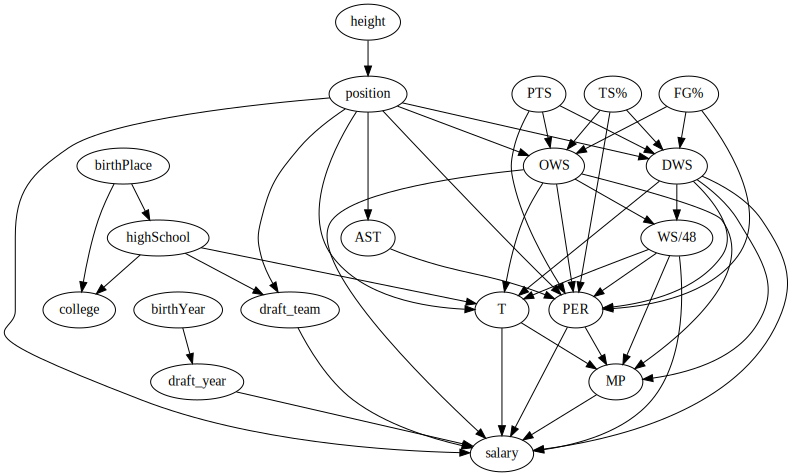

In [235]:
import graphviz
import networkx as nx
dot = graphviz.Digraph(comment='Causal Graph')
causal_graph = nx.DiGraph()
for att in avg_treat_salary.columns:
    dot.node(att, att)
    causal_graph.add_node(att)
        
edges = [('birthPlace', 'college'), ('birthPlace', 'highSchool'),
         ('birthYear', 'draft_year'),
         ('draft_team', 'salary'),
         ('draft_year', 'salary'),
         ('highSchool', 'T'), ('highSchool', 'college'), ('highSchool', 'draft_team'), 
         ('position', 'draft_team'), ('position', 'PER'), ('position', 'salary'), ('position', 'AST'), ('position', 'OWS'), ('position', 'DWS'), ('position', 'T'),
         ('height', 'position'),
         ('PER', 'salary'), ('PER', 'MP'),
         ('PTS', 'OWS'), ('PTS', 'DWS'), ('PTS', 'PER'),
         ('TS%', 'OWS'), ('TS%', 'DWS'), ('TS%', 'PER'),
         ('MP', 'salary'),
         ('OWS', 'salary'), ('OWS', 'PER'), ('OWS', 'MP'), ('OWS', 'WS/48'), ('OWS', 'T'),
         ('DWS', 'salary'), ('DWS', 'PER'), ('DWS', 'MP'), ('DWS', 'WS/48'), ('DWS', 'T'),
         ('WS/48', 'salary'), ('WS/48', 'PER'), ('WS/48', 'MP'), ('WS/48', 'T'),
         ('FG%', 'OWS'), ('FG%', 'DWS'), ('FG%', 'PER'),
         ('AST', 'PER'),
         ('T', 'salary'), ('T', 'MP')
         ]
# Create edges
for edge in edges:
    dot.edge(edge[0], edge[1])
    causal_graph.add_edge(edge[0], edge[1])

try:
    nx.find_cycle(causal_graph, orientation="original")
except:
    print("No cycles found")
dot

In [236]:
string_graph = str(dot).replace('\n', ';\n').replace('};', '}').replace('{;', '{').replace('h;', 'h').rstrip()
string_graph = string_graph[string_graph.find('// Causal Graph\n')+len('// Causal Graph\n'):]

In [237]:
avg_treat_salary.columns

Index(['birthPlace', 'college', 'draft_team', 'draft_year', 'highSchool',
       'position', 'birthYear', 'height', 'salary', 'PER', 'PTS', 'TS%', 'MP',
       'OWS', 'DWS', 'WS/48', 'FG%', 'AST', 'T'],
      dtype='object')

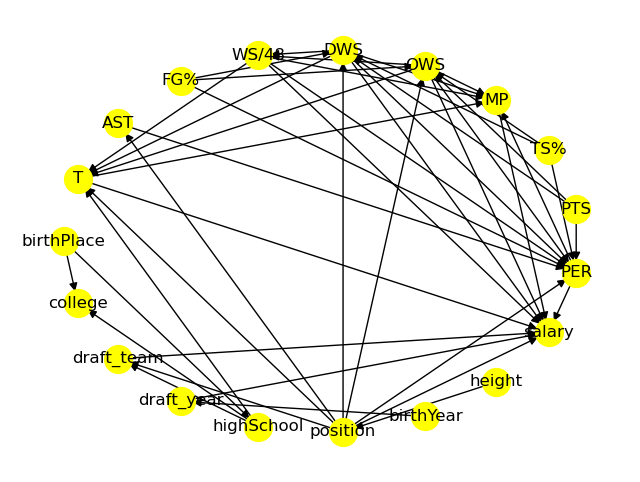

In [238]:
model=dowhy.CausalModel(data=avg_treat_salary, graph=string_graph, treatment='T', outcome='salary')
model.view_model()
identified_estimand = model.identify_effect()

In [239]:
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                               
────(E[salary|DWS,WS/48,position,highSchool,OWS])
d[T]                                             
Estimand assumption 1, Unconfoundedness: If U→{T} and U→salary then P(salary|T,DWS,WS/48,position,highSchool,OWS,U) = P(salary|T,DWS,WS/48,position,highSchool,OWS)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [240]:
help(dowhy.CausalModel.estimate_effect)

Help on function estimate_effect in module dowhy.causal_model:

estimate_effect(self, identified_estimand, method_name=None, control_value=0, treatment_value=1, test_significance=None, evaluate_effect_strength=False, confidence_intervals=False, target_units='ate', effect_modifiers=None, fit_estimator=True, method_params=None)
    Estimate the identified causal effect.
    
    Currently requires an explicit method name to be specified. Method names follow the convention of identification method followed by the specific estimation method: "[backdoor/iv].estimation_method_name". Following methods are supported.
        * Propensity Score Matching: "backdoor.propensity_score_matching"
        * Propensity Score Stratification: "backdoor.propensity_score_stratification"
        * Propensity Score-based Inverse Weighting: "backdoor.propensity_score_weighting"
        * Linear Regression: "backdoor.linear_regression"
        * Generalized Linear Models (e.g., logistic regression): "backdoor.

In [241]:
# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching", confidence_intervals=True)
print("backdoor.propensity_score_matching")
print(causal_estimate)
# causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.generalized_linear_model")
# print("backdoor.generalized_linear_model")
# print(causal_estimate)

propensity_score_matching
backdoor.propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                               
────(E[salary|DWS,WS/48,position,highSchool,OWS])
d[T]                                             
Estimand assumption 1, Unconfoundedness: If U→{T} and U→salary then P(salary|T,DWS,WS/48,position,highSchool,OWS,U) = P(salary|T,DWS,WS/48,position,highSchool,OWS)

## Realized estimand
b: salary~T+DWS+WS/48+position+highSchool+OWS
Target units: ate

## Estimate
Mean value: 322536.4146960207
95.0% confidence interval: (120638.28298625117, 789653.8873864606)



-84021.99150464899

Mean value: 322536.4146960207